# Investigating MODIS Data
E.g. for bowtie effect

## Earth Access

In [6]:
# EARTHDATA_USERNAME 
# EARTHDATA_PASSWORD 
# environment variables

import os
import earthaccess
import xarray as xr

os.environ['EARTHDATA_USERNAME'] = ''
os.environ['EARTHDATA_PASSWORD'] = ''

In [3]:
# try: short_name='MOD02HKM'
# count: if set to a n, search_data returns the first n results - if n is greater than the number of results, all results are returned

results = earthaccess.search_data(
    short_name='MOD021KM',
    cloud_hosted=True,
    bounding_box=(-10, 20, 10, 50),
    temporal=("2018-10-01 08:00", "2018-10-01 11:00"),
    count=-1
)

Authentication with Earthdata Login failed with:
{"error":"invalid_header","error_description":"Invalid header"}
Granules found: 3


In [4]:
results

[Collection: {'ShortName': 'MOD021KM', 'Version': '6.1'}
 Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Longitude': -7.820944, 'Latitude': 48.615273}, {'Longitude': 22.900313, 'Latitude': 44.459754}, {'Longitude': 38.493195, 'Latitude': 60.213084}, {'Longitude': -8.461157, 'Latitude': 66.899476}, {'Longitude': -7.820944, 'Latitude': 48.615273}]}}]}}}
 Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2018-10-01T10:30:00.000Z', 'EndingDateTime': '2018-10-01T10:35:00.000Z'}}
 Size(MB): 167.403575897217
 Data: ['https://ladsweb.modaps.eosdis.nasa.gov/archive/allData/61/MOD021KM/2018/274/MOD021KM.A2018274.1030.061.2018274200208.hdf'],
 Collection: {'ShortName': 'MOD021KM', 'Version': '6.1'}
 Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Longitude': -9.762663, 'Latitude': 30.785606}, {'Longitude': 14.294732, 'Latitude': 27.52965}, {'Longitude': 22.400958, 'Latitude': 44.68

In [5]:
files = earthaccess.download(results, "./modisdata/earthaccess2/")

Authentication with Earthdata Login failed with:
{"error":"invalid_header","error_description":"Invalid header"}
'NoneType' object has no attribute 'get'
You must call earthaccess.login() before you can download data


In [10]:
ds = xr.open_dataset('./modisdata/earthaccess2/MOD021KM.A2018274.1030.061.2018274200208.hdf', engine='netcdf4')
ds

<xarray.Dataset>
Dimensions:                                            (
                                                        2*nscans:MODIS_SWATH_Type_L1B: 406,
                                                        1KM_geo_dim:MODIS_SWATH_Type_L1B: 271,
                                                        Band_1KM_RefSB:MODIS_SWATH_Type_L1B: 15,
                                                        10*nscans:MODIS_SWATH_Type_L1B: 2030,
                                                        Max_EV_frames:MODIS_SWATH_Type_L1B: 1354,
                                                        ...
                                                        number of scans: 203,
                                                        number of 250m bands: 2,
                                                        detectors per 250m band: 40,
                                                        number of 500m bands: 5,
                                                        detectors per 500m band: 20,
                                                        number of 1km reflective bands: 15)
Coordinates:
  * Band_250M                                          (Band_250M) float32 1....
  * Band_500M                                          (Band_500M) float32 3....
  * Band_1KM_RefSB                                     (Band_1KM_RefSB) float32 ...
  * Band_1KM_Emissive                                  (Band_1KM_Emissive) float32 ...
Dimensions without coordinates: 2*nscans:MODIS_SWATH_Type_L1B,
                                1KM_geo_dim:MODIS_SWATH_Type_L1B,
                                Band_1KM_RefSB:MODIS_SWATH_Type_L1B,
                                10*nscans:MODIS_SWATH_Type_L1B,
                                Max_EV_frames:MODIS_SWATH_Type_L1B,
                                Band_1KM_Emissive:MODIS_SWATH_Type_L1B,
                                ...
                                Band_500M:MODIS_SWATH_Type_L1B,
                                number of emissive bands,
                                detectors per 1km band, number of scans,
                                number of 250m bands, detectors per 250m band,
                                number of 500m bands, detectors per 500m band,
                                number of 1km reflective bands
Data variables: (12/27)
    Latitude                                           (2*nscans:MODIS_SWATH_Type_L1B, 1KM_geo_dim:MODIS_SWATH_Type_L1B) float32 ...
    Longitude                                          (2*nscans:MODIS_SWATH_Type_L1B, 1KM_geo_dim:MODIS_SWATH_Type_L1B) float32 ...
    EV_1KM_RefSB                                       (Band_1KM_RefSB:MODIS_SWATH_Type_L1B, 10*nscans:MODIS_SWATH_Type_L1B, Max_EV_frames:MODIS_SWATH_Type_L1B) float32 ...
    EV_1KM_RefSB_Uncert_Indexes                        (Band_1KM_RefSB:MODIS_SWATH_Type_L1B, 10*nscans:MODIS_SWATH_Type_L1B, Max_EV_frames:MODIS_SWATH_Type_L1B) float32 ...
    EV_1KM_Emissive                                    (Band_1KM_Emissive:MODIS_SWATH_Type_L1B, 10*nscans:MODIS_SWATH_Type_L1B, Max_EV_frames:MODIS_SWATH_Type_L1B) float32 ...
    EV_1KM_Emissive_Uncert_Indexes                     (Band_1KM_Emissive:MODIS_SWATH_Type_L1B, 10*nscans:MODIS_SWATH_Type_L1B, Max_EV_frames:MODIS_SWATH_Type_L1B) float32 ...
    ...                                                 ...
    Noise in Thermal Detectors                         (number of emissive bands, detectors per 1km band) uint8 ...
    Change in relative responses of thermal detectors  (number of emissive bands, detectors per 1km band) uint8 ...
    DC Restore Change for Thermal Bands                (number of scans, number of emissive bands, detectors per 1km band) int8 ...
    DC Restore Change for Reflective 250m Bands        (number of scans, number of 250m bands, detectors per 250m band) int8 ...
    DC Restore Change for Reflective 500m Bands        (number of scans, number of 500m bands, detectors per 500m band) int8 ...
    DC Restore Cha

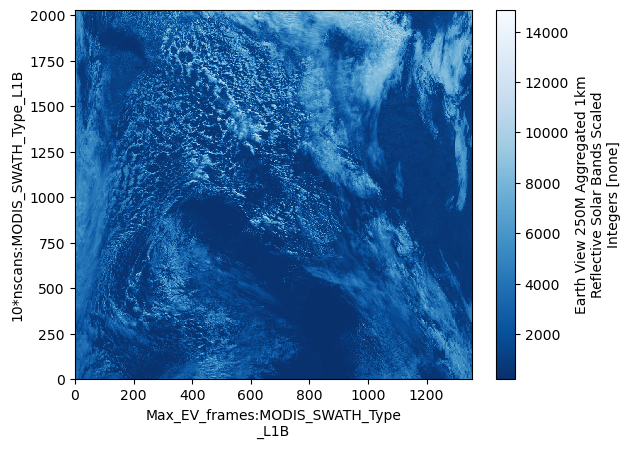

In [11]:
ds.EV_250_Aggr1km_RefSB[0].plot(cmap='Blues_r') # band 1

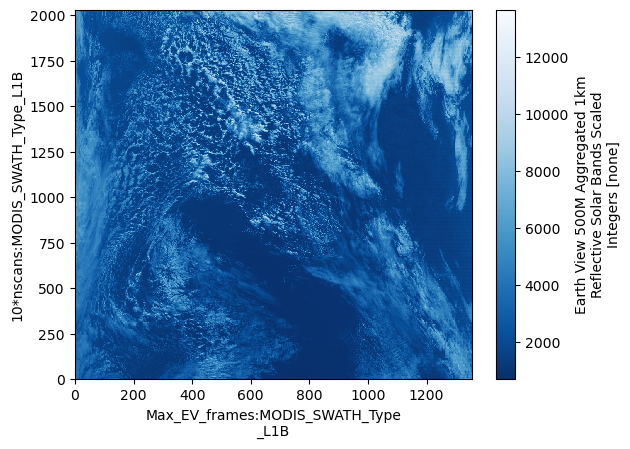

In [12]:
ds.EV_500_Aggr1km_RefSB[0].plot(cmap='Blues_r') # band 3

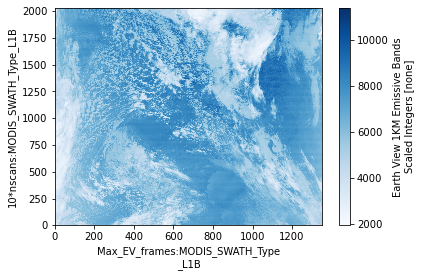

In [45]:
ds.EV_1KM_Emissive[5].plot(cmap='Blues') # band 25

In [26]:
ds

<xarray.Dataset>
Dimensions:                                            (
                                                        2*nscans:MODIS_SWATH_Type_L1B: 406,
                                                        1KM_geo_dim:MODIS_SWATH_Type_L1B: 271,
                                                        Band_1KM_RefSB:MODIS_SWATH_Type_L1B: 15,
                                                        10*nscans:MODIS_SWATH_Type_L1B: 2030,
                                                        Max_EV_frames:MODIS_SWATH_Type_L1B: 1354,
                                                        ...
                                                        number of scans: 203,
                                                        number of 250m bands: 2,
                                                        detectors per 250m band: 40,
                                                        number of 500m bands: 5,
                                                        detectors per 500m band: 20,
                                                        number of 1km reflective bands: 15)
Coordinates:
  * Band_250M                                          (Band_250M) float32 1....
  * Band_500M                                          (Band_500M) float32 3....
  * Band_1KM_RefSB                                     (Band_1KM_RefSB) float32 ...
  * Band_1KM_Emissive                                  (Band_1KM_Emissive) float32 ...
Dimensions without coordinates: 2*nscans:MODIS_SWATH_Type_L1B,
                                1KM_geo_dim:MODIS_SWATH_Type_L1B,
                                Band_1KM_RefSB:MODIS_SWATH_Type_L1B,
                                10*nscans:MODIS_SWATH_Type_L1B,
                                Max_EV_frames:MODIS_SWATH_Type_L1B,
                                Band_1KM_Emissive:MODIS_SWATH_Type_L1B,
                                ...
                                Band_500M:MODIS_SWATH_Type_L1B,
                                number of emissive bands,
                                detectors per 1km band, number of scans,
                                number of 250m bands, detectors per 250m band,
                                number of 500m bands, detectors per 500m band,
                                number of 1km reflective bands
Data variables: (12/27)
    Latitude                                           (2*nscans:MODIS_SWATH_Type_L1B, 1KM_geo_dim:MODIS_SWATH_Type_L1B) float32 ...
    Longitude                                          (2*nscans:MODIS_SWATH_Type_L1B, 1KM_geo_dim:MODIS_SWATH_Type_L1B) float32 ...
    EV_1KM_RefSB                                       (Band_1KM_RefSB:MODIS_SWATH_Type_L1B, 10*nscans:MODIS_SWATH_Type_L1B, Max_EV_frames:MODIS_SWATH_Type_L1B) float32 ...
    EV_1KM_RefSB_Uncert_Indexes                        (Band_1KM_RefSB:MODIS_SWATH_Type_L1B, 10*nscans:MODIS_SWATH_Type_L1B, Max_EV_frames:MODIS_SWATH_Type_L1B) float32 ...
    EV_1KM_Emissive                                    (Band_1KM_Emissive:MODIS_SWATH_Type_L1B, 10*nscans:MODIS_SWATH_Type_L1B, Max_EV_frames:MODIS_SWATH_Type_L1B) float32 ...
    EV_1KM_Emissive_Uncert_Indexes                     (Band_1KM_Emissive:MODIS_SWATH_Type_L1B, 10*nscans:MODIS_SWATH_Type_L1B, Max_EV_frames:MODIS_SWATH_Type_L1B) float32 ...
    ...                                                 ...
    Noise in Thermal Detectors                         (number of emissive bands, detectors per 1km band) uint8 ...
    Change in relative responses of thermal detectors  (number of emissive bands, detectors per 1km band) uint8 ...
    DC Restore Change for Thermal Bands                (number of scans, number of emissive bands, detectors per 1km band) int8 ...
    DC Restore Change for Reflective 250m Bands        (number of scans, number of 250m bands, detectors per 250m band) int8 ...
    DC Restore Change for Reflective 500m Bands        (number of scans, number of 500m bands, detectors per 500m band) int8 ...
    DC Restore Cha

In [ ]:
ds.EV_500_Aggr1km_RefSB[0]